<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

# dfdsf

## Import libraries
Use "pip install libName" in terminal if any of them is not installed on your machine.

In [145]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter
import cv2
from sklearn import metrics
from scipy.io import loadmat
import imutils
import json
import statistics


# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Discovering digitalStruct file

In [128]:
with open('SVHN/train/digitStruct.json') as f:
    data = json.load(f)
print(type(data))
print("sample data item:\n", data[0])
print("each item is of type: ", type(data[0]))
print("each item has 2 keys: ", data[0].keys())
print("each boxes is a", type(data[0]['boxes']), "of: ", len(data[0]['boxes']), type(data[0]['boxes'][0]))
print("first dict has ", data[0]['boxes'][0].keys())
print("second dict has ", data[0]['boxes'][1].keys())
for i in range(len(data)):
    data[i]['filename'] = 'train/'+data[i]['filename']

<class 'list'>
sample data item:
 {'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
each item is of type:  <class 'dict'>
each item has 2 keys:  dict_keys(['filename', 'boxes'])
each boxes is a <class 'list'> of:  2 <class 'dict'>
first dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])
second dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])


In [131]:
scipy.loadmat("/SVHN/train/digitStruct.mat")

AttributeError: module 'scipy' has no attribute 'loadmat'

## Import Pics with labels

In [146]:
def getPics(chosen_set):
    images = []
    labels = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)

    print("There are ", len(data), " images in " + chosen_set + " set.")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [144]:
print(type(data))
print(type(data[1]))
print(type(data[1]['boxes']))
print(data[1]['boxes'][0])
print(type(data[1]['boxes'][0]))

<class 'list'>
<class 'dict'>
<class 'list'>
{'height': 32.0, 'label': 2.0, 'left': 77.0, 'top': 29.0, 'width': 23.0}
<class 'dict'>


In [81]:
def getPicsCropped(chosen_set):
    images = []
    gs_images = []
    labels = []

    picsFolder_path = "SVHN/" + chosen_set + "_32x32.mat"
    data = scipy.io.loadmat(picsFolder_path)
    images = data['X']
    labels = data['y']
    images = np.array(images)
    images = np.moveaxis(images, -1, 0)
    gs_images = np.array(gs_images)
    gs_images = np.moveaxis(gs_images, -1, 0)
    labels = np.array(labels)
    print(images.shape[0],"cropped images in 32x32 " + chosen_set + " set.")
    return images, labels

73257 cropped images in 32x32 train set.
(73257, 32, 32, 3)


In [156]:
train_images, train_labels = getPics("train")

There are  33402  images in train set.


- Calculating images median and mean resolution

In [83]:
sizes = []
for img in train_images:
    sizes.append(img.shape[0]*img.shape[1])
imgs_median_size = statistics.median(sizes)
imgs_mean_size = statistics.mean(sizes)

print("Average image size is:", imgs_mean_size)
print("Median image size is:", imgs_median_size)

Average image size is: 1024
Median image size is: 1024


## Model that visualize biggest convex hull for cropped images

Label:  [3]


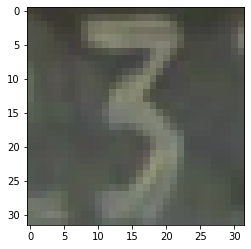

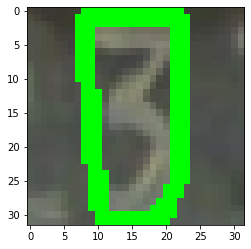

In [112]:
def croppedHullModel(img):
    image = img.copy()
    # image2 = img.copy()
    img_res = img.shape[0]*img.shape[1]
    g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(g, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    hull = cv2.convexHull(cnts[0])
    cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)    
    return image

i=5555
print("Label: ", train_labels[i])
plt.figure("Original")
plt.imshow(train_images[i])
plt.figure("Hull Model")
ans = croppedHullModel(train_images[i])
plt.imshow(ans)


## Model that visualize biggest rectangle for cropped images

Label:  [2]


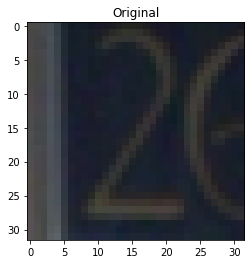

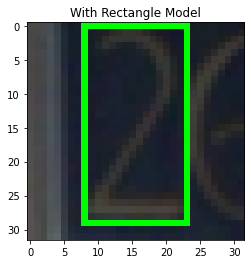

In [126]:
def croppedRectangleModel(img):
    image = img.copy()
    # image2 = img.copy()
    img_res = img.shape[0]*img.shape[1]
    g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(g, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(cnts[0])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    
    # cnts_a = []
    # for c in cnts:
    #     cnts_a.append(cv2.contourArea(c))
    # cnts_m = np.percentile(cnts_a,60)
    # for i in range(len(cnts)):
        # x, y, w, h = cv2.boundingRect(c)
        # if ( img_res < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50) or (image.shape[0] < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50):
        #     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # if(cnts_a[i]>cnts_m):
        #     hull = cv2.convexHull(cnts[i])
        #     cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)
    return image

i=55666
print("Label: ", train_labels[i])
plt.figure("Original")
plt.title("Original")
plt.imshow(train_images[i])
plt.figure("With Rectangle Model")
plt.title("With Rectangle Model")
ans = croppedRectangleModel(train_images[i])
plt.imshow(ans)
plt.show()

- View sample image

sample train image of lable(s):  [4. 2.]


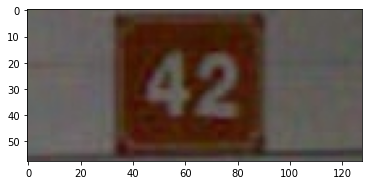

In [175]:
i = 12
print("sample train image of lable(s): ",train_labels[i] )
plt.imshow(train_images[i])
plt.show()

- Convert to grayscale

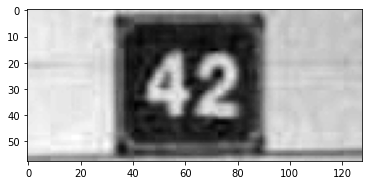

In [176]:
gray = cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

- Gaussian blur

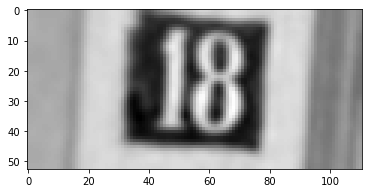

In [151]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

- Canny edge detection

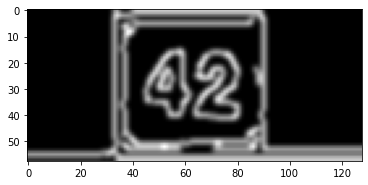

In [177]:
edged = cv2.Canny(gray, 20, 100, 255)
edged_smoothed = cv2.GaussianBlur(edged, (5, 5), 0)

plt.imshow(edged_smoothed, cmap='gray')
plt.show()


- Finding countours

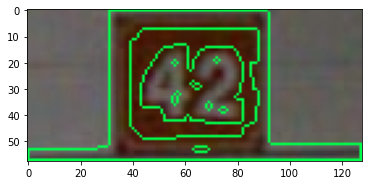

In [178]:
contours, hierarchy  = cv2.findContours(edged_smoothed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
temp = train_images[i]
cv2.drawContours(temp, contours, -1, (0,255,75), 1)
plt.imshow(temp)
plt.show()

10.0
6.0
4.0
4.0


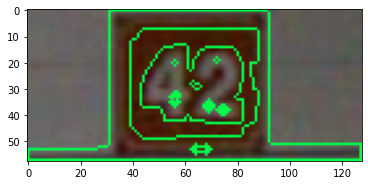

In [179]:
# find contours in the edge map, then sort them by their size in descending order
# cnts = imutils.grab_contours(contours)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
img = train_images[i].copy()
i = 0

for j in cnts:
    if (cv2.isContourConvex(j) and i < 4):
        img = cv2.drawContours(img, j, -1, (0, 255, 75), 2)
        print(cv2.contourArea(j))
        i += 1
plt.imshow(img)
plt.show()

# displayCnt = None
# loop over the contours
# for c in cnts:
# 	# approximate the contour
# 	peri = cv2.arcLength(c, True)
# 	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
# 	# if the contour has four vertices, then we have found the thermostat display
# 	if len(approx) == 4:
# 		displayCnt = approx
# 		break


sample cropped train image of lable(s):  [2]


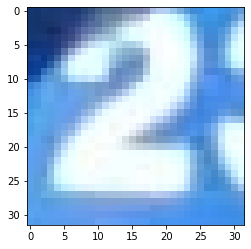

In [ ]:
i = 2
print("sample cropped train image of lable(s): ",cropped_train_labels[i] )
plt.imshow(cropped_train_images[i])
plt.show()

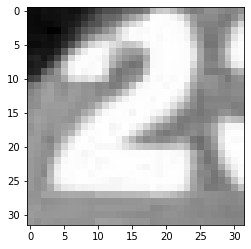

In [35]:
gray = cv2.cvtColor(cropped_train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

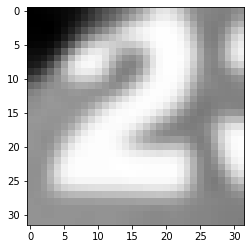

In [36]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

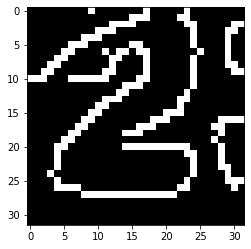

In [37]:
edged = cv2.Canny(blurred, 40, 100, 255)
plt.imshow(edged, cmap='gray')
plt.show()

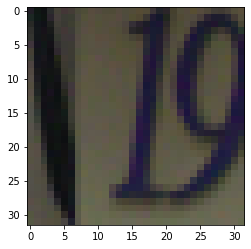

[1]


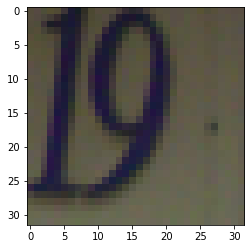

[9]


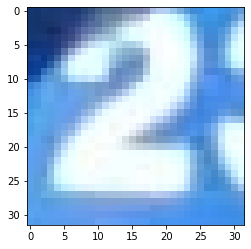

[2]


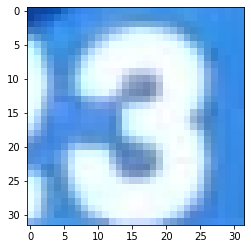

[3]


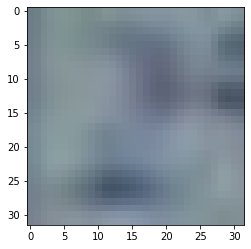

[2]


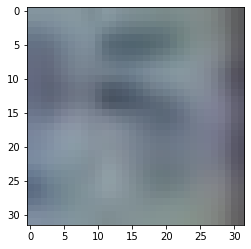

[5]


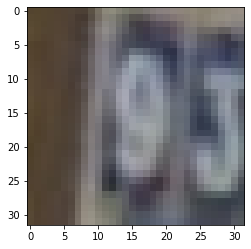

[9]


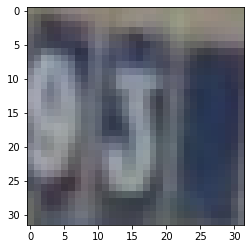

[3]


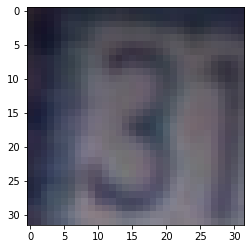

[3]


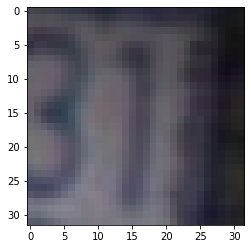

[1]


In [41]:
for i in range(10):
    plt.imshow(cropped_train_images[i, :, :, :])
    plt.show()
    print(cropped_train_labels[i])